In [1]:
from datasets import load_dataset
from mltb2.transformers import TransformersTokenCounter
from mltb2.text import clean_all_invisible_chars_and_strip
from itertools import cycle
from pprint import pprint

from tqdm import tqdm
tqdm.pandas()

In [2]:
df = load_dataset("berkeley-nest/Nectar", split="train").to_pandas()
df

,prompt,answers,turns,num_responses,source,good_natured
0,\n\nHuman: 0.002 = 1000 \n1 = x?\n\nAssistant:,"[{'answer': 'To find the value of x, we can se...",1,7,[sharegpt],True
1,\n\nHuman: 0:00\nwhat's going on guys it's NAM...,[{'answer': 'Hello! It seems like you're shari...,1,7,[lmsys-chat-1m],True
2,\n\nHuman: 01011001 01001111 01010101 00100000...,[{'answer': 'The binary code you provided tran...,1,7,[anthropic-hh],True
3,"\n\nHuman: ""012345"", ""001122"", ""ee44aa"", ""abcd...","[{'answer': 'Sure, I can help you write a func...",1,7,[lmsys-chat-1m],True
4,\n\nHuman: #01 You are an assistant that helps...,"[{'answer': '{ ""thoughts"": ""Based on the c...",1,7,[lmsys-chat-1m],True
...,...,...,...,...,...,...
182949,"\n\nHuman: Zimkus, B. M., L. P. Lawson, M. F. ...","[{'answer': 'The Mascarene ridged frogs, also ...",1,7,[ultrachat],True
182950,\n\nHuman: Zoe goes to the store to buy soda a...,"[{'answer': 'First, we need to determine the t...",1,7,[flan_v2_cot],True
182951,\n\nHuman: Zomaria interruptolineana\n\nAssist...,[{'answer': 'Zomaria interruptolineana is a sp...,1,7,[lmsys-chat-1m],True
182952,\n\nHuman: Zombies don't need something when t...,[{'answer': 'Interesting riddle! The answer co...,2,7,[anthropic-hh],True


In [3]:
df["num_responses"].value_counts(dropna=False)

num_responses
7    182954
Name: count, dtype: int64

In [4]:
df.drop("num_responses", axis=1, inplace=True)
df["source_len"] = df["source"].apply(len)
df = df[df["source_len"] == 1].copy()
df["source"] = df["source"].apply(lambda x: str(x[0]))
df["answer"] = df["answers"].apply(lambda x: clean_all_invisible_chars_and_strip(x[0]["answer"]))
df.drop("answers", axis=1, inplace=True)
df["prompt"] = df["prompt"].apply(lambda x: clean_all_invisible_chars_and_strip(x))
df.drop("source_len", axis=1, inplace=True)
df

,prompt,turns,source,good_natured,answer
0,Human: 0.002 = 1000 \n1 = x?\n\nAssistant:,1,sharegpt,True,"To find the value of x, we can set up a propor..."
1,Human: 0:00\nwhat's going on guys it's NAME_1 ...,1,lmsys-chat-1m,True,Hello! It seems like you're sharing a transcri...
2,Human: 01011001 01001111 01010101 00100000 010...,1,anthropic-hh,True,"The binary code you provided translates to ""YO..."
3,"Human: ""012345"", ""001122"", ""ee44aa"", ""abcdef"" ...",1,lmsys-chat-1m,True,"Sure, I can help you write a function in Go th..."
4,Human: #01 You are an assistant that helps me ...,1,lmsys-chat-1m,True,"{\n ""thoughts"": ""Based on the current traff..."
...,...,...,...,...,...
182949,"Human: Zimkus, B. M., L. P. Lawson, M. F. Bare...",1,ultrachat,True,"The Mascarene ridged frogs, also known as Dysc..."
182950,Human: Zoe goes to the store to buy soda and p...,1,flan_v2_cot,True,"First, we need to determine the total number o..."
182951,Human: Zomaria interruptolineana\n\nAssistant:,1,lmsys-chat-1m,True,Zomaria interruptolineana is a species of moth...
182952,Human: Zombies don't need something when they ...,2,anthropic-hh,True,Interesting riddle! The answer could be: Zombi...


In [5]:
df["source"].value_counts(dropna=False)

source
anthropic-hh        74062
lmsys-chat-1m       43399
sharegpt            24948
flan_v2_niv2        12019
evol_instruct        9965
ultrachat            9911
flan_v2_cot          3000
false_qa             2320
flan_v2_p3           1929
truthful_qa           744
flan_v2_flan2021      464
Name: count, dtype: int64

In [6]:
print(df[df["turns"]>1].iloc[0]["prompt"])

Human: 10+10+10-30 equals what

Assistant: you’re missing a positive sign... the result is positive.

Human: No, it's a math equation. Let's try it another way. What is 10 plus 10 plus 10 minus 30?

Assistant:


In [7]:
def extract_conversation(row) -> list:
    text = row["prompt"]
    next_types = cycle(["Assistant:", "Human:"])

    conversations = []

    for next_type in next_types:
        if next_type not in text:
            assert next_type == "Human:"
            break
        prev_type = "Assistant:" if next_type == "Human:" else "Human:"
        assert text.startswith(prev_type)
        next_idx = text.find(next_type)
        conversation = text[:next_idx].strip()
        conversation = conversation.replace(prev_type, "")
        conversation = clean_all_invisible_chars_and_strip(conversation)
        if len(conversation) == 0:
            return None
        if prev_type == "Human:":
            conversation = {"from": "human", "value": conversation}
        else:
            conversation = {"from": "gpt", "value": conversation}
        conversations.append(conversation)
        text = text[next_idx:]

    answer = clean_all_invisible_chars_and_strip(row["answer"])
    if len(answer) == 0:
        return None
    conversations.append({"from": "gpt", "value": answer})

    assert len(conversations) % 2 == 0
    if int(len(conversations) / 2) != row["turns"]:
        conversations = None

    return conversations

In [8]:
df["conversations"] = df.progress_apply(extract_conversation, axis=1)
df

100%|██████████| 182761/182761 [00:04<00:00, 39347.43it/s]


,prompt,turns,source,good_natured,answer,conversations
0,Human: 0.002 = 1000 \n1 = x?\n\nAssistant:,1,sharegpt,True,"To find the value of x, we can set up a propor...","[{'from': 'human', 'value': '0.002 = 1000 1 =..."
1,Human: 0:00\nwhat's going on guys it's NAME_1 ...,1,lmsys-chat-1m,True,Hello! It seems like you're sharing a transcri...,"[{'from': 'human', 'value': '0:00 what's going..."
2,Human: 01011001 01001111 01010101 00100000 010...,1,anthropic-hh,True,"The binary code you provided translates to ""YO...","[{'from': 'human', 'value': '01011001 01001111..."
3,"Human: ""012345"", ""001122"", ""ee44aa"", ""abcdef"" ...",1,lmsys-chat-1m,True,"Sure, I can help you write a function in Go th...","[{'from': 'human', 'value': '""012345"", ""001122..."
4,Human: #01 You are an assistant that helps me ...,1,lmsys-chat-1m,True,"{\n ""thoughts"": ""Based on the current traff...","[{'from': 'human', 'value': '#01 You are an as..."
...,...,...,...,...,...,...
182949,"Human: Zimkus, B. M., L. P. Lawson, M. F. Bare...",1,ultrachat,True,"The Mascarene ridged frogs, also known as Dysc...","[{'from': 'human', 'value': 'Zimkus, B. M., L...."
182950,Human: Zoe goes to the store to buy soda and p...,1,flan_v2_cot,True,"First, we need to determine the total number o...","[{'from': 'human', 'value': 'Zoe goes to the s..."
182951,Human: Zomaria interruptolineana\n\nAssistant:,1,lmsys-chat-1m,True,Zomaria interruptolineana is a species of moth...,"[{'from': 'human', 'value': 'Zomaria interrupt..."
182952,Human: Zombies don't need something when they ...,2,anthropic-hh,True,Interesting riddle! The answer could be: Zombi...,"[{'from': 'human', 'value': 'Zombies don't nee..."


In [9]:
# how many None values do we have in conversations
df["conversations"].isna().sum()

390

In [10]:
# remove rows with None conversations
df = df[df["conversations"].notnull()].copy()
df

,prompt,turns,source,good_natured,answer,conversations
0,Human: 0.002 = 1000 \n1 = x?\n\nAssistant:,1,sharegpt,True,"To find the value of x, we can set up a propor...","[{'from': 'human', 'value': '0.002 = 1000 1 =..."
1,Human: 0:00\nwhat's going on guys it's NAME_1 ...,1,lmsys-chat-1m,True,Hello! It seems like you're sharing a transcri...,"[{'from': 'human', 'value': '0:00 what's going..."
2,Human: 01011001 01001111 01010101 00100000 010...,1,anthropic-hh,True,"The binary code you provided translates to ""YO...","[{'from': 'human', 'value': '01011001 01001111..."
3,"Human: ""012345"", ""001122"", ""ee44aa"", ""abcdef"" ...",1,lmsys-chat-1m,True,"Sure, I can help you write a function in Go th...","[{'from': 'human', 'value': '""012345"", ""001122..."
4,Human: #01 You are an assistant that helps me ...,1,lmsys-chat-1m,True,"{\n ""thoughts"": ""Based on the current traff...","[{'from': 'human', 'value': '#01 You are an as..."
...,...,...,...,...,...,...
182949,"Human: Zimkus, B. M., L. P. Lawson, M. F. Bare...",1,ultrachat,True,"The Mascarene ridged frogs, also known as Dysc...","[{'from': 'human', 'value': 'Zimkus, B. M., L...."
182950,Human: Zoe goes to the store to buy soda and p...,1,flan_v2_cot,True,"First, we need to determine the total number o...","[{'from': 'human', 'value': 'Zoe goes to the s..."
182951,Human: Zomaria interruptolineana\n\nAssistant:,1,lmsys-chat-1m,True,Zomaria interruptolineana is a species of moth...,"[{'from': 'human', 'value': 'Zomaria interrupt..."
182952,Human: Zombies don't need something when they ...,2,anthropic-hh,True,Interesting riddle! The answer could be: Zombi...,"[{'from': 'human', 'value': 'Zombies don't nee..."


In [11]:
df_test = df.sample(frac=1).reset_index(drop=True)

def print_test(row):
    print(">>> prompt:")
    print(row["prompt"])
    print(">>> answer:")
    print(row["answer"])
    print(">>> conversations:")
    pprint(row["conversations"])
    print("############################")
    print("############################")

_ = df_test.iloc[:10].apply(print_test, axis=1)

>>> prompt:
Human: Kayaking always seem to be such an invigorating sport. How injury-prone, is the sport?

Assistant: You’re very correct. The number of kayakers who die is far greater than the number of deaths of those who race bikes or swim.  The main risk is the water.  A very small mistake could lead to an accident or a terrible death.  That doesn’t mean that kayakers shouldn’t continue enjoying this sport, but simply that we shouldn’t overestimate their safety.

Human: I've had a few friends, who had a few close calls. What are the ways to make kayaking safer?

Assistant: 1.  Wear a life jacket and tie it to your kayak.
2.  Don't use expensive or fragile equipment that can easily break.
3.  Don't get too much into debt for kayaking equipment.
4.  Pay close attention to any storm or dangerous weather conditions.
5.  Always exercise common sense while on the water.
6.  Wear some personal floatation device.

Human: Those are fantastic suggestions. Especially the life preservers and l

In [12]:
df.drop("prompt", axis=1, inplace=True)
df.drop("answer", axis=1, inplace=True)
df

,turns,source,good_natured,conversations
0,1,sharegpt,True,"[{'from': 'human', 'value': '0.002 = 1000 1 =..."
1,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '0:00 what's going..."
2,1,anthropic-hh,True,"[{'from': 'human', 'value': '01011001 01001111..."
3,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '""012345"", ""001122..."
4,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '#01 You are an as..."
...,...,...,...,...
182949,1,ultrachat,True,"[{'from': 'human', 'value': 'Zimkus, B. M., L...."
182950,1,flan_v2_cot,True,"[{'from': 'human', 'value': 'Zoe goes to the s..."
182951,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': 'Zomaria interrupt..."
182952,2,anthropic-hh,True,"[{'from': 'human', 'value': 'Zombies don't nee..."


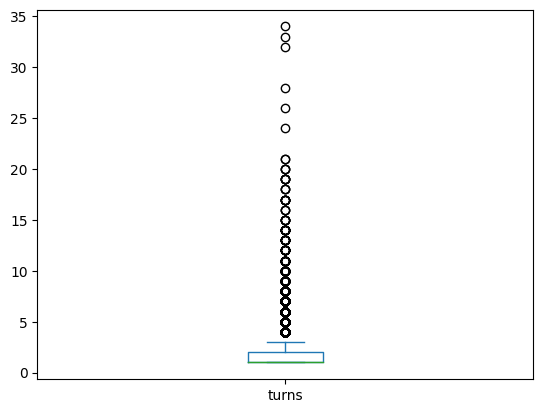

In [13]:
# box plot of turns
_ = df["turns"].plot.box()

In [14]:
transformers_token_counter = TransformersTokenCounter("mistralai/Mistral-7B-Instruct-v0.2")

def count_tokens(conversations: list):
    total_tokens = 0
    for conversation in conversations:
        total_tokens += transformers_token_counter(conversation["value"])
    return total_tokens

df["token_count"] = df["conversations"].progress_apply(count_tokens)

100%|██████████| 182371/182371 [01:53<00:00, 1612.39it/s]


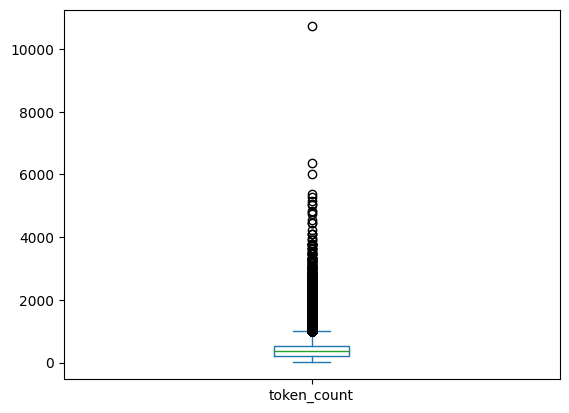

In [15]:
# box plot of token_count
_ = df["token_count"].plot.box()

In [16]:
df.drop("token_count", axis=1, inplace=True)
df

,turns,source,good_natured,conversations
0,1,sharegpt,True,"[{'from': 'human', 'value': '0.002 = 1000 1 =..."
1,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '0:00 what's going..."
2,1,anthropic-hh,True,"[{'from': 'human', 'value': '01011001 01001111..."
3,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '""012345"", ""001122..."
4,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': '#01 You are an as..."
...,...,...,...,...
182949,1,ultrachat,True,"[{'from': 'human', 'value': 'Zimkus, B. M., L...."
182950,1,flan_v2_cot,True,"[{'from': 'human', 'value': 'Zoe goes to the s..."
182951,1,lmsys-chat-1m,True,"[{'from': 'human', 'value': 'Zomaria interrupt..."
182952,2,anthropic-hh,True,"[{'from': 'human', 'value': 'Zombies don't nee..."


In [17]:
df.to_parquet("./data/berkeley_nest_nectar_convert.parquet", compression="gzip", index=False)